In [9]:
import casadi as ca
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy.integrate
import numpy as np
import control

from casadi.tools.graph import dotgraph
from IPython.display import Image

def draw_graph(expr):
    return Image(dotgraph(expr).create_png())

# Parameters
$
W = 162,000 lb\\
thrust = 30000 lb\\
S = 2170 ft^2\\
b = 140 ft\\
length = 90 ft\\
I_{yy} = 4.1 e^6 slug-ft^2
$

In [10]:
def eom(x,u):
    s = 2170
    cbar = 17.5
    mass = 5.0e3
    iyy = 4.1e6
    tstat = 6.0e4
    dtdv = -38.0
    ze = 2.0
    cdcls = 0.042
    cla = 0.085
    cma = -0.022
    cmde = -0.016
    cmq = -16.0
    cmadot = -6.0
    cladot = 0.0
    rtod = 57.29578
    gd = 32.17
    
    # INPUTS
    # u = [thtl elev xcg land phi]
    
    thtl = u[0]
    elev_deg = u[1]
    xcg = u[2]
    land = u[3]
    phi = u[4]
    phi_deg = rtod*phi # tilt angle, deg
    
    # STATES
    # x = [vt alpha theta q h p]
    
    vt = x[0]  # velocity, ft/s
    alpha = x[1] # AOA
    alpha_deg = rtod*alpha  # angle of attack, deg
    theta = x[2]  # pitch angle, rad
    q = x[3]  # pitch rate, rad/s
    h = x[4]  # altitude, ft
    p = x[5]  # horizontal pos
    
    r0 = 2.377e-3
    tfac = 1.0 - 0.703e-5*h
    temperature = ca.if_else(h > 35000, 390.0, 519.0*tfac)
    rho = r0*tfac**4.14
    mach = vt/ca.sqrt(1.4*1716.3*temperature)
    qbar = 0.5*rho*vt**2
    
    qs = qbar*s
    salp = ca.sin(alpha)
    calp = ca.cos(alpha)
    beta = phi+alpha
    beta_deg = rtod*beta
    sbet = ca.sin(beta)
    cbet = ca.cos(beta)
    
    gam = theta - alpha
    sgam = ca.sin(gam)
    cgam = ca.cos(gam)
    
    aero_p = ca.if_else(
        land,
        (1.0, 0.08, -0.20, 0.02, -0.05),
        (0.2, 0.016, 0.05, 0.0, 0.0)
        )
    cl0 = aero_p[0]
    cd0 = aero_p[1]
    cm0 = aero_p[2]
    dcdg = aero_p[3]
    dcmg = aero_p[4]
    
    thr = (tstat + vt*dtdv)*ca.fmax(thtl, 0)
    cl = cl0 + cla*(beta_deg)
    cm = dcmg + cm0 + cma*(beta_deg) + cmde*elev_deg + cl*(xcg - 0.25)
    cd = dcdg + cd0 + cdcls*cl**2
        
    # x = [vt alpha theta q h p phi]
    
    x_dot = ca.SX.zeros(6)
    x_dot[0] = (thr*cbet - qs*cd)/mass - gd*sgam
    x_dot[1] = (-thr*sbet - qs*cl + mass*(vt*q + gd*cgam))/(mass*vt + qs*cladot)
    x_dot[2] = q
    d = 0.5*cbar*(cmq*q + cmadot*x_dot[1])/vt
    x_dot[3] = (qs*cbar*(cm + d) + thr*ze)/iyy
    x_dot[4] = vt*sgam
    x_dot[5] = vt*cgam
    return x_dot

In [11]:
# x = ca.SX.sym('x',6)
# u = ca.SX.sym('u',5)
# f_eom = ca.Function('eom',[x,u],[eom(x,u)],['x','u'],['dx'],{'jit': True})
# draw_graph(eom(x,u))

In [12]:
def constraint(s, vt, h, gamma):
    
    # s is our design vector:
    # s = [thtl, elev_deg, alpha, phi]
    thtl = s[0]
    elev_deg = s[1]
    alpha = s[2]
    phi = s[3]
    
    pos = 0  # we don't care what horiz. position we are at
    q = 0 # we don't want to be rotating, so no pitch-rate
    xcg = 0.25  # we assume xcg at 1/4 chord
    land = 0  # we assume we do not have flaps/gear deployed
    theta = alpha + gamma
    
    # vt, alpha, theta, q, h, pos
    x = ca.vertcat(vt, alpha, theta, q, h, pos)
    
    # thtl, elev_deg, xcg, land
    u = ca.vertcat(thtl, elev_deg, xcg, land, phi)
    return x, u

def trim_cost(x, u):
    x_dot = eom(x, u)
    return x_dot[0]**2 + 100*x_dot[1]**2 + 10*x_dot[3]**2

def objective(s, vt, h, gamma):
    x, u = constraint(s, vt, h, gamma)
    return trim_cost(x, u)

def trim(vt, h, gamma):
    s = ca.SX.sym('s', 4)
    nlp = {'x': s, 'f': objective(s, vt, h, gamma)}
    S = ca.nlpsol('S', 'ipopt', nlp, {
        'print_time': 0,
        'ipopt': {
            'sb': 'yes',
            'print_level': 0,
            }
        })

    # s = [thtl, elev_deg, alpha]
    # u = [thtl elev xcg land phi]
    
    s0 = [0.293, 2.46, np.deg2rad(0.58), 0]
    s0 = [0,0,0,0]
    res = S(x0=s0)
    return np.array(res['x'])

In [13]:
trim(500,10000,0)

array([[0.24155885],
       [1.0609384 ],
       [0.01080899],
       [0.01727405]])

* u = [thtl elev xcg land phi]
* s = [thtl, elev_deg, alpha, phi]
* x = [vt, alpha, theta, q, h, p]


-0.001302 s^4 - 0.0004485 s^3 - 0.0001041 s^2 - 4.584e-09 s + 2.149e-19
-----------------------------------------------------------------------
  s^5 + 0.501 s^4 + 0.2264 s^3 + 0.01434 s^2 + 0.009476 s - 2.062e-08



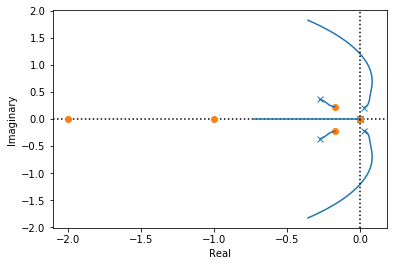

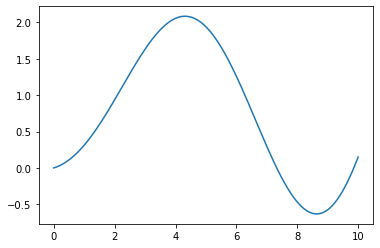

In [7]:
x = ca.SX.sym('x',6)
u = ca.SX.sym('u',5)
y = x
f_eom = ca.Function('eom',[x,u],[eom(x,u)],['x','u'],['x_dot'])
A = ca.jacobian(f_eom(x,u),x)
B = ca.jacobian(f_eom(x,u),u)
C = ca.jacobian(y,x)
D = ca.jacobian(y,u)

f_ss = ca.Function('f_ss',[x,u],[A,B,C,D],['x','u'],['A','B','C','D'])
vt = 100
h = 10000 
gamma = 0
svec = trim(vt, h, gamma)
x0,u0 = constraint(svec,vt,h,gamma)

sys = control.ss(*f_ss(np.array(x0),np.array(u0)))
G_elev = control.ss2tf(sys[3,1])
print(G_elev)
s = control.tf([1,0],[0,1])
H = -100*(s+1)*(s+2)/s**2
control.rlocus(H*G_elev,kvect=np.linspace(0,10,1000));
Gc = control.feedback(H*G_elev,1)
t,y = control.step_response(Gc,T=np.linspace(0,10,1000));
plt.figure()
plt.plot(t,y)

In [100]:
tf = 3000/2
res = scipy.integrate.solve_ivp(
    fun=lambda t, x: np.array(f_eom(x, [float(s[0]),float(s[1]),0.25,0,float(s[3])])).reshape(-1),
    t_span=[0, tf],
    y0=[500,0,0,0,10000,0],
    t_eval=np.arange(0, tf, 0.1))

plt.figure()
plt.plot(res['t'], res['y'][0, :]);
plt.title('V vs t')
plt.xlabel('time[s]')
plt.ylabel('V[ft/s]')

plt.figure()
plt.plot(res['y'][5,:],res['y'][4,:])
plt.title('Trajectory')
plt.xlabel('pos[ft]')
plt.ylabel('altittude[ft]')
plt.grid()

TypeError: cannot unpack non-iterable int object